# **DeepLIFT: Практика**

DeepLIFT в некоторой степени продолжает идею Integrated gradients, концентрируясь на суммировании активаций относительно некоторых "базовых" активаций на базовом примере. По определению метода в [оригинальной статье](https://arxiv.org/abs/1704.02685), нет никаких ограничений на применение к какой-либо модальности данных или модели. Но в силу специфичности метода он работает в реализации не для всех архитектур и адаптирован только на изображения на момент написания курса. Поэтому эта практика тоже посвящена работе с изображениями :)


Как прежде в курсе, будем работать с реализацией, помогающей интерпретировать pyTorch модели. В этом нам поможет уже знакомая библиотека [captum](https://captum.ai/).

Deep LIFT также доступен для использования с моделями, обученными при помощи фреймворка Keras. Данную реализацию можно найти в одноименной библиотеке [deeplift](https://github.com/kundajelab/deeplift).  

**Интересный и редкий для XAI факт**: [DeepLIFT адаптирован](https://www.kaggle.com/code/marcellveiner/deeplift-exploration-on-genomic-data) под применение к genomic данным для Keras моделей и при помощи библиотек обработки genomic data, например [tangermeme](https://tangermeme.readthedocs.io/en/latest/index.html).

В этой практике вы:
- Попрактикуетесь в использовании библиотеки captum
- Оцените различные baselines для метода deepLIFT

In [ ]:
!pip install captum -q

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import numpy as np

%matplotlib inline

import torch
from io import BytesIO
import requests
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision.models import swin_t

from captum.attr import DeepLift
from captum.attr import visualization as viz

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import alexnet

import urllib

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

В этот раз чуть больше поработаем с прекрасной хрюшкой. Сделаем все стандартные шаги:
- загрузку изображения
- написание функций для предобработки
- предобработку изображения

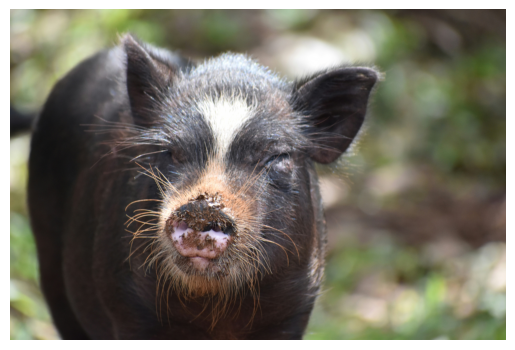

In [ ]:
hog_url = 'https://github.com/SadSabrina/explainable_AI_course/blob/main/HW_module10.2_gradient_methods/hog.jpg?raw=true'

hog_image_bytes = requests.get(hog_url).content
image = Image.open(BytesIO(hog_image_bytes))

plt.axis('off')
plt.imshow(image);

1. Допишите функцию preprocess, добавив нормализацию (``` transforms.Normalize(mean=[..., ..., ...], std=[..., ..., ...]) ```) изображения. Почему нам заранее известно какие средние и стандартные отклонения вычислять?

In [ ]:
#Предобработка

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),

# Ваш код здесь
)
])

display = transforms.Compose([transforms.Resize((224,224))])


In [ ]:
input = preprocess(image)

input.unsqueeze_(0);
input.requires_grad = True

В прошлых практиках мы работали с моделями, чья топ-5 accuracy превышает 90%. В этот раз, для интереса, рассмотрим модель "послабее" — AlexNet с топ-5 accuracy 79%.

In [ ]:
alex_net = alexnet(weights='IMAGENET1K_V1');

2. Получите прогноз модели для хрюшки. Какой класс прогнозирует AlexNet?

In [ ]:
# Ваш код здесь
output =

print('Прогноз модели: ', torch.max(output, 1)[1])

Прогноз модели:  tensor([341])


3. Получите и последовательно расшифруйте топ-5 прогнозов, используя список `categories`.

In [ ]:
top_5_classes = torch.topk(output, k=5)

indexes, probabilities = # # Ваш код здесь

for i, j in zip(indexes,probabilities):
  print(i, categories[i], 'probability: ', j)

Рассмотрим, что заставляет модель видеть в хрюшке polecat — хорька при помощи DeepLIFT.
![31731a18913711ee801af6c574779d3e-upscaled.md.jpg](https://ltdfoto.ru/images/2024/08/19/31731a18913711ee801af6c574779d3e-upscaled.md.jpg)

Для начала, как и в прошлом уроке, сгенерируем baselines! В этот раз добавим один новый — среднее по каналам, вычисленное на основе Imagenet.

In [ ]:
def gaussian_noise(x, var):
  """
  Гауссовский шум на основе изображения x
  """

  return torch.normal(0, var, size=x.shape)


def random_baseline(x, low, high):
    """
    Cлучайное распределение на основе изображения x
    """

    return np.random.uniform(low, high, size=x.shape)



In [ ]:
zero_baseline = input * 0 #Zero baseline

noise_baseline = torch.ones_like(input) # Noise baseline
noise_baseline += gaussian_noise(input, 0.1)

mean_baseline = torch.ones_like(input) # Mean baseline
mean_baseline *= torch.mean(input, axis=1)

mean_imagenet_baseline = torch.ones_like(input) # Mean baseline IMAGENET
mean_imagenet_baseline[0, 0] = mean_imagenet_baseline[0, 0]*0.485
mean_imagenet_baseline[0, 1] = mean_imagenet_baseline[0, 1]*0.456
mean_imagenet_baseline[0, 2] =  mean_imagenet_baseline[0, 2]*0.406


random_baseline = random_baseline(x=input, low=0, high=15) # Random baseline
random_baseline = torch.from_numpy(random_baseline).float()

Аналогично практике по IG сделаем функцию для удобной визуализации

In [ ]:
def vizualize_tensor(tensor):

  if len(tensor.shape) == 4:
    return tensor.squeeze(0).permute((1, 2, 0)).detach().numpy()
  else:
    return tensor.permute((1, 2, 0)).detach().numpy()

In [ ]:
# Создание фигуры и сетки 1x5
fig, axes = plt.subplots(1, 5, figsize=(16, 8))

# Отображение каждого изображения строка 1
axes[0].imshow(vizualize_tensor(zero_baseline))
axes[0].set_title('Zero baseline')

axes[1].imshow(vizualize_tensor(noise_baseline))
axes[1].set_title('Noise baseline')

axes[2].imshow(vizualize_tensor(mean_baseline))
axes[2].set_title('Mean baseline')

axes[3].imshow(vizualize_tensor(random_baseline))
axes[3].set_title('Random baseline');

axes[4].imshow(vizualize_tensor(mean_imagenet_baseline))
axes[4].set_title('Mean IMAGENET baseline');

Как и в прошлой практике, для работы с градиентным методом объяснения из captum вам потребуется `DeepLIFT` (его мы снова уже импортировали в первой ячейке) и метод .attribute — с почти точно такими же параметрами, как и для Integrated Gradients.



```
attribute(inputs, baselines=None, target=None, additional_forward_args=None, return_convergence_delta=False, custom_attribution_func=None)[source]¶

```
где:
- inputs — входные изображения
- baselines - baselines изображений
- target — класс, по которому будет строится объяснение
- additional_forward_args — в случае если модель возвращает не только стандартный output, но и другие объекты Python
- return_convergence_delta — разница между общими приближенными и истинными интегрированными градиентами
- custom_attribution_func — в случае, если вы хотите вычислять атрибуции особым методом.

Таке у самого DeepLIFT есть гиперпараметры:
- multiply_by_inputs (bool, опциональный) — указывает, следует ли учитывать входной baseline. В литературе это также известно как локальная или глобальная атрибуция ([тут](https://arxiv.org/abs/1711.06104) можно прочесть подробнее).  Если входные данне baseline не учитываются, то этот тип метода атрибуции также называется локальной атрибуцией, если наоборот, то этот тип метода атрибуции называется глобальным.
- eps (float, опциональный) — значение, при котором следует считать изменение выходных/входных данных значительным при вычислении градиентов для нелинейных слоев. Полезно для настройки глубоких моделей, чтобы избежать проблем при вычислении градиента. По умолчанию: 1e-10

In [ ]:
alex_net.zero_grad()
dl = DeepLift(alex_net) # Инициализируем DeepLIFT

Вычислим атрибуции с помощью deepLIFT. Здесь код ничем не отличается от нашей практики по Integrated Gradients.

In [ ]:
dl_zero_attributions = dl.attribute(input, zero_baseline, 358)
dl_noise_attributions = dl.attribute(input, noise_baseline, 358)
dl_mean_attributions = dl.attribute(input, mean_baseline, 358)
dl_mean_imagenet_attributions = dl.attribute(input, mean_imagenet_baseline, 358)
dl_random_attributions = dl.attribute(input, random_baseline, 358)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


**Визуализация. Встроенный метод.**

Теперь попробуем визуализировать значения напрямую.

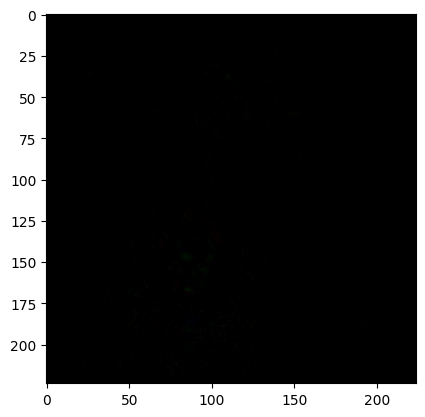

In [ ]:
plt.imshow(vizualize_tensor(dl_zero_attributions));

Черный квадрат! Но действительно ли все значения в нём показывают отсутствие информации?

Найдите минимальное и максимальное значение в `dl_zero_attributions`. Укажите в ответ на степик найденный минимум.

In [ ]:
# Ваш код здесь

Наверное, на этом шаге вы уже догадываетесь в чем проблема черного квадарата — значения слишком маленькие (об этом, кстати, нам говорит Warning) и в прошлой практике мы домножали их на 10.

Как уловить градиенты? С одной стороны, всё уже рализовано в библиотеке `captum` под капотом, и мы можем этим воспользоваться, используя метод `visualize_image_attr` из модуля `viz` в `captum`.

```
captum.attr.visualization.visualize_image_attr(attr,
                                              original_image=None,
                                              method='heat_map',
                                              sign='absolute_value',
                                              plt_fig_axis=None,
                                              outlier_perc=2, cmap=None,
                                              alpha_overlay=0.5,
                                              show_colorbar=False, title=None,
                                              fig_size=(6, 6), use_pyplot=True)
```

Параметров у метода много и многие понятны интуитивно. На практике очень полезным оказывается не сколько использование наложенной тепловой карты, сколько *использование маски* из полученной карты на оригинальном изображении. Задать визуализацию в виде маски (и в целом вид визуализации) можно при помощи гиперпараметра `method`.


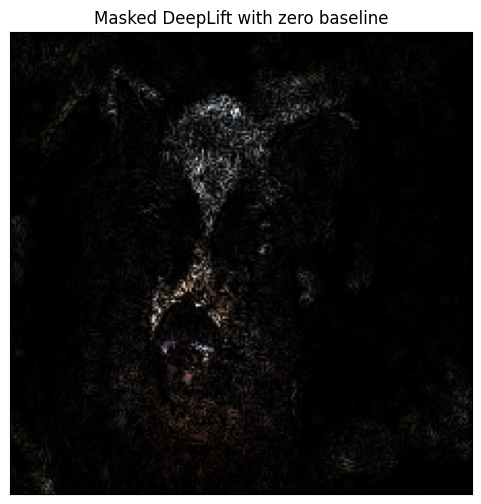

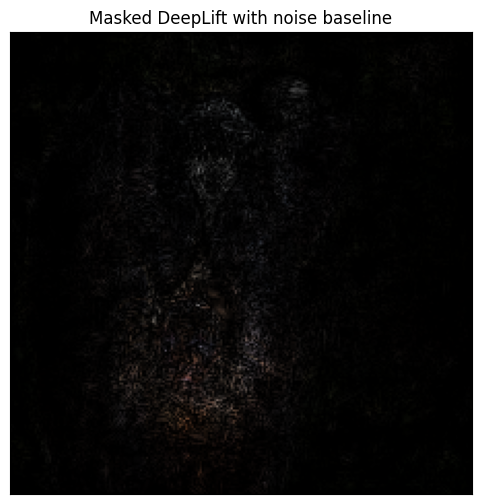

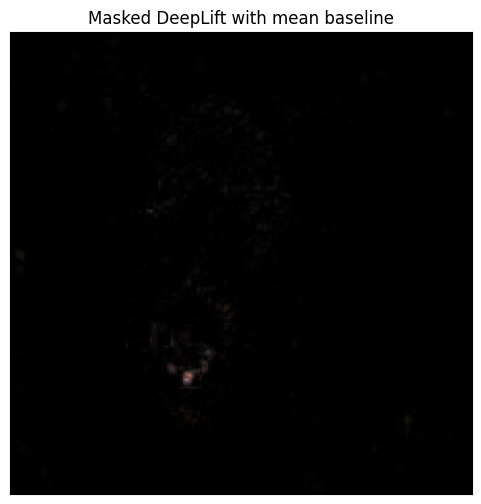

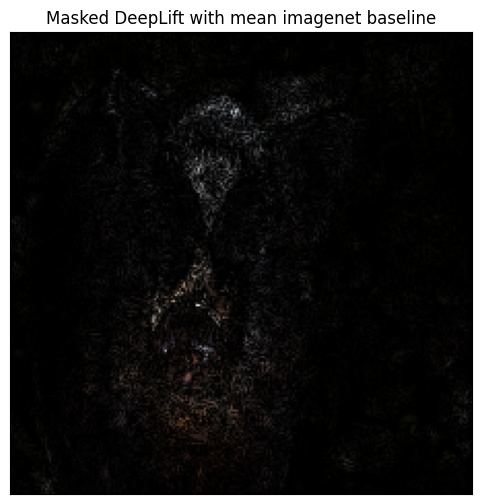

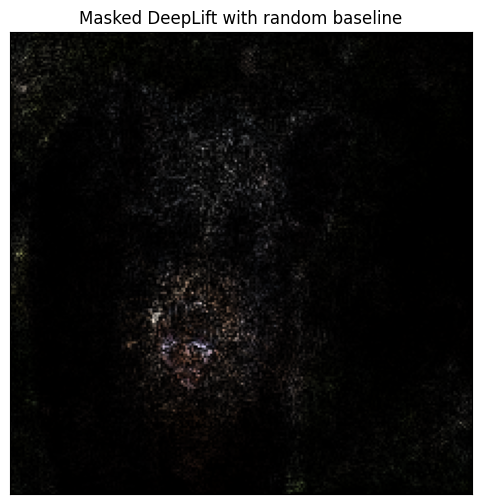

In [ ]:
#Визуализируем все карты при помощи масок

_ = viz.visualize_image_attr(vizualize_tensor(dl_zero_attributions),
                             np.array(display(image)),
                             method="masked_image",
                             sign="absolute_value",
                             title="Masked DeepLift with zero baseline")

_ = viz.visualize_image_attr(vizualize_tensor(dl_noise_attributions),
                             np.array(display(image)),
                             method="masked_image",
                             sign="absolute_value",
                              title="Masked DeepLift with noise baseline")

_ = viz.visualize_image_attr(vizualize_tensor(dl_mean_attributions),
                             np.array(display(image)),
                             method="masked_image",
                             sign="absolute_value",
                             title="Masked DeepLift with mean baseline")

_ = viz.visualize_image_attr(vizualize_tensor(dl_mean_imagenet_attributions),
                             np.array(display(image)),
                             method="masked_image",
                             sign="absolute_value",
                             title="Masked DeepLift with mean imagenet baseline")

_ = viz.visualize_image_attr(vizualize_tensor(dl_random_attributions),
                             np.array(display(image)),
                             method="masked_image",
                             sign="absolute_value",
                            title="Masked DeepLift with random baseline")

Какой из baselines показывает наиболее сжатую информацию (дает на выходе более разреженную карту)? Выберите ответ на степик.

На масках видно, что окрас свинки может отдаленно напоминать хорька. Однако такой вывод — больше гипотеза, которую нужно тестировать, исправляя данные и эксперементируя с другими изображениями.

**Визуализация. Ручная корректировка.**

Вернемся к проблеме маленьких значений. Второй путь — масштабировать значения к большему масштабу, сохраняя при этом их смысл. Сделать это можно при помощи, например, MinMax Scaling:

$$MinMax(X) = \frac{X-min(X)}{max(X)-min(X)}$$

Какой максимум будет у такого преобразования?

Реализуйте MinMax scaling в виде функции и примените её ко всем картам.

In [ ]:
def MinMaxScaling(X):

  min_val = X.min()
  max_val = X.max()

  return (X - min_val)/(max_val - min_val)

In [ ]:
for attr in [dl_zero_attributions, dl_noise_attributions, dl_random_attributions, dl_mean_attributions, dl_mean_imagenet_attributions]:

  normalized_map =  MinMaxScaling(attr)
  plt.imshow(vizualize_tensor(normalized_map))
  plt.show()

На этом наша практика заканчивается. Спасибо! Будем рады, если вы попробуете поэксперементировать и поделитесь, что получалось у вас при экспериментах с собственными изображениям!

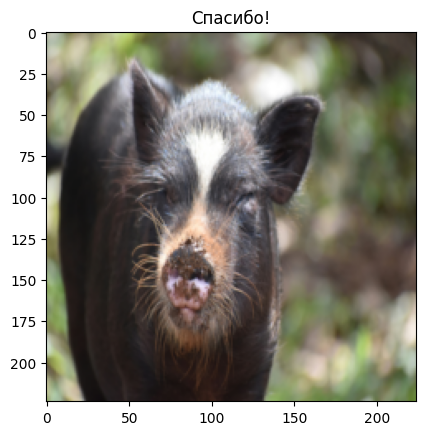

In [ ]:
plt.imshow(display(image))
plt.title('Спасибо!');